# This notebook is from sctrach teaching myself about the Bayesian inversion for Euler pole/TRW in terms of plate motion reconstruction

It will be largely based on Chapter 4 of Ian Rose's PhD thesis with a goal of:
- converting the code into pymc3
- refining the choices of prescribed statistical conditions and apply recent advancement of MCMC algorithm
- linking the code toward pmagpy software package (?)

In [11]:
import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag
import IPython
import pandas as pd
import matplotlib
import numpy as np
import numpy.polynomial.legendre as legendre
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import random
import copy

import seaborn as sb
from scipy.constants import Julian_year
from scipy.special import erf, erfi

import pymc3 as pm
# import pymc
# import mcplates

from pymc3 import distributions
from pymc3.distributions import Continuous, draw_values, generate_samples
import theano.tensor as T
from theano.compile.ops import as_op
from theano import shared
import theano
from pymc3.theanof import floatX

%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

## Handy constants

In [2]:
d2r = np.pi/180
r2d = 180/np.pi
eps = 1.e-6

Let's start with the very basics

# Try reproducing mcplates apparent polar wander path Bayesian inversion in PyMC3

## pole rotation functions

In [6]:

# @as_op(itypes=[T.dvector, T.dvector, T.dscalar], otypes=[T.dvector])
def rotate(pole, rotation_pole, angle):
    # The idea is to rotate the pole so that the Euler pole is
    # at the pole of the coordinate system, then perform the
    # requested rotation, then restore things to the original
    # orientation
    carttodir = cartesian_to_spherical(rotation_pole)
    lon, lat, intensity = carttodir[0], carttodir[1], carttodir[2]
    
    colat = 90. - lat
    m1 = construct_euler_rotation_matrix(-lon
                                         * d2r, -colat * d2r, angle * d2r)
    m2 = construct_euler_rotation_matrix(0., colat * d2r, lon * d2r)
    return np.dot(m2, np.dot(m1, pole))


def construct_euler_rotation_matrix(alpha, beta, gamma):
    """
    Make a 3x3 matrix which represents a rigid body rotation,
    with alpha being the first rotation about the z axis,
    beta being the second rotation about the y axis, and
    gamma being the third rotation about the z axis.

    All angles are assumed to be in radians
    """
    rot_alpha = np.array([[np.cos(alpha), -np.sin(alpha), 0.],
                          [np.sin(alpha), np.cos(alpha), 0.],
                          [0., 0., 1.]])
    rot_beta = np.array([[np.cos(beta), 0., np.sin(beta)],
                         [0., 1., 0.],
                         [-np.sin(beta), 0., np.cos(beta)]])
    rot_gamma = np.array([[np.cos(gamma), -np.sin(gamma), 0.],
                          [np.sin(gamma), np.cos(gamma), 0.],
                          [0., 0., 1.]])
    rot = np.dot(rot_gamma, np.dot(rot_beta, rot_alpha))
    return rot

def spherical_to_cartesian(longitude, latitude, norm = 1):
    #    assert(np.all(longitude >= 0.) and np.all(longitude <= 360.))
    #    assert(np.all(latitude >= -90.) and np.all(latitude <= 90.))
    #    assert(np.all(norm >= 0.))
    colatitude = 90. - latitude
    return np.array([norm * np.sin(colatitude * d2r) * np.cos(longitude * d2r),
                     norm * np.sin(colatitude * d2r) * np.sin(longitude * d2r),
                     norm * np.cos(colatitude * d2r)])

def cartesian_to_spherical(vecs):
    v = np.reshape(vecs, (3, -1))
    norm = np.sqrt(v[0, :] * v[0, :] + v[1, :] * v[1, :] + v[2, :] * v[2, :])
    latitude = 90. - np.arccos(v[2, :] / norm) * r2d
    longitude = np.arctan2(v[1, :],v[0, :]) * r2d

    return longitude, latitude, norm

# now the longitude will be constrained to be within 0 to 360 degrees
def clamp_longitude( lons ):
    lons = np.asarray(lons)
    lons = np.fmod(lons, 360.)
    lons[np.where(lons < 0)] += 360.
    return lons    

def two_sigma_from_kappa(kappa):
    return 140. / np.sqrt(kappa)


def kappa_from_two_sigma(two_sigma):
    return 140. * 140. / two_sigma / two_sigma


In [3]:
class APWP(object):

    def __init__(self, name, paleomagnetic_pole_list, n_euler_poles, sample_size = 2000):
        for p in paleomagnetic_pole_list:
            assert (isinstance(p, PaleomagneticPole))

        self._name = name
        self._poles = paleomagnetic_pole_list
        self.n_euler_rotations = n_euler_poles

        self._age_list = [p._age for p in self._poles]
        self._start_age = max(self._age_list)
        self._start_pole = self._poles[np.argmax(self._age_list)]
        self._sample_size = sample_size 
    
    def create_model(self, site_lon_lat=[1., 0.], k=1., kw = -1., euler_rate=1., tpw_rate_scale = None):
        assert euler_rate > 0.0, "rate_scale must be a positive number."
        assert tpw_rate_scale == None or tpw_rate_scale > 0.0
        assert kw <= 0.0, "Nonnegative Watson concentration parameters are not supported."
        if tpw_rate_scale is None:
            self.include_tpw = False
        else:
            self.include_tpw = True
            
        with pm.Model() as APWP_model:   
            start = VMF('start', 
                        lon_lat=[self._start_pole.longitude, self._start_pole.latitude], 
                        k=kappa_from_two_sigma(self._start_pole._A95), 
                        testval = np.array([1., 0.]), shape = 2)
            
#             if self.n_euler_rotations == 0 and tpw_rate_scale!= None:
#                 tpw_pole_angle = pm.Uniform('tpw_pole_angle', 0., 360., value=0., observed=False)
#                 tpw_rate = pm.Exponential('tpw_rate', tpw_rate_scale)
                
#             elif self.n_euler_rotations == 1:
#                 euler_1 = VMF('euler_1', lon_lat = [1., 0.], k = k, testval = np.array([1., 0.]), shape = 2)
#                 rate_1 = pm.Exponential('rate_1', euler_rate) 

#                 for i in range(len(self._poles)):
#                     p = self._poles[i]

#                     if p._age_type == 'gaussian':
#                         pole_age = pm.Normal('t'+str(i), mu=self._age_list[i], tau=1/(p._sigma_age**-2))
#                     elif p._age_type == 'uniform':
#                         pole_age = pm.Uniform('t'+str(i), lower=p._sigma_age[0], upper=p._sigma_age[1])

#                     lon_lat = pole_position_1e(start, euler_1, rate_1, pole_age )
#                     observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(p._A95), observed=[p.longitude, p.latitude])
                    
#             elif self.n_euler_rotations == 2:
                
            euler_1 = VMF('euler_1', lon_lat = site_lon_lat, k = k, testval = np.array([1., 0.]), shape = 2)
            rate_1 = pm.Exponential('rate_1', euler_rate) 
            euler_2 = VMF('euler_2', lon_lat = site_lon_lat, k = k, testval = np.array([1., 0.]), shape = 2)
            rate_2 = pm.Exponential('rate_2', euler_rate) 
            switchpoint = pm.Uniform('switchpoint', min(self._age_list), max(self._age_list))
                
            for i in range(len(self._poles)):
                p = self._poles[i]

                if p._age_type == 'gaussian':
                    pole_age = pm.Normal('t'+str(i), mu=self._age_list[i], tau=1/(p._sigma_age**-2))
                elif p._age_type == 'uniform':
                    pole_age = pm.Uniform('t'+str(i), lower=p._sigma_age[0], upper=p._sigma_age[1])

                lon_lat = pole_position(start, euler_1, rate_1, euler_2, rate_2, switchpoint, pole_age )
                observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(p._A95), observed=[p.longitude, p.latitude])
                    
            trace = pm.sample(self._sample_size, step = pm.Metropolis())
#             for i in range(len(self._poles)):
#                 p = self._poles[i]

# #                 time = self._start_age
#                 if p._age_type == 'gaussian':
#                     pole_age = pm.Normal('t'+str(i), mu=self._age_list[i], tau=1/(p._sigma_age**-2))
#                 elif p._age_type == 'uniform':
#                     pole_age = pm.Uniform('t'+str(i), lower=p._sigma_age[0], upper=p._sigma_age[1])

#                 if self.n_euler_rotations == 2:
#                     lon_lat = pole_position(start, eulers[0], rates[0], eulers[1], rates[1], changes[0], pole_age)
#                 lon_lat = pole_position(start, euler_1, rate_1, euler_2, rate_2, switchpoint, pole_age )
#                 observed_pole = VMF('p'+str(i), lon_lat, k=kappa_from_two_sigma(p._A95), observed=[p.longitude, p.latitude])
#                 observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(p._A95), observed=[p.longitude, p.latitude])
#             if self.include_tpw:
#                 tpw_pole_angle = pm.Uniform('tpw_pole_angle', lower = 0., upper = 360.)
#                 tpw_rate = pm.Exponential('tpw_rate', tpw_rate_scale)
                   
        return trace

## Pole father class

In [4]:
# based on poles.py by I. Rose

class Pole(object):
    """
    Class representing a pole on the globe:
    essentially a 3-vector with some additional
    properties and operations.
    """

    def __init__(self, longitude, latitude, magnitude = 1, A95=None):
        """
        Initialize the pole with lon, lat, and A95 uncertainty. Removed norm from Rose version, here we assume everything is unit vector. 
        longitude, latitude, and A95 are all taken in degrees.
        """
        self.longitude = longitude
        self.latitude = latitude
        self.colatitude = 90 - latitude
        self.magnitude = magnitude
        self._pole = spherical_to_cartesian(self.longitude, self.latitude, self.magnitude) # pole position in cartesian coordinates, easier for addition operations
        self._A95 = A95

#     @property
#     def longitude(self):
#         return np.arctan2(self._pole[1], self._pole[0]) * rot.r2d

#     @property
#     def latitude(self):
#         return 90. - np.arccos(self._pole[2] / self.norm) * rot.r2d

#     @property
#     def colatitude(self):
#         return np.arccos(self._pole[2] / self.norm) * rot.r2d

#     @property
#     def norm(self):
#         return np.sqrt(self._pole[0] * self._pole[0] + self._pole[1] * self._pole[1] + self._pole[2] * self._pole[2])

#     @property
#     def angular_error(self):
#         return self._angular_error

    def copy(self):
        return copy.deepcopy(self)

    def rotate(self, pole, angle):
        # The idea is to rotate the pole about a given pole
        # at the pole of the coordinate system, then perform the
        # requested rotation, then restore things to the original
        # orientation
        p = pole._pole
        
        lon, lat, intensity = cartesian_to_spherical(p)
        colat = 90. - lat
        m1 = construct_euler_rotation_matrix(-lon * d2r, -colat * d2r, angle * d2r)
        m2 = construct_euler_rotation_matrix(0., colat * d2r, lon * d2r)
        self._pole = np.dot(m2, np.dot(m1, self._pole))
        self.longitude = cartesian_to_spherical(self._pole.tolist())[0].tolist()[0]
        self.latitude = cartesian_to_spherical(self._pole.tolist())[1].tolist()[0]
        self._pole = spherical_to_cartesian(self.longitude, self.latitude, self.magnitude)
        self.colatitude = 90 - self.latitude

    def _rotate(self, pole, angle):
        print(self.longitude, self.latitude)
        p = pole._pole
        
        lon, lat, intensity = cartesian_to_spherical(p)
        lon = T.as_tensor_variable(lon[0])
        lat = T.as_tensor_variable(lat[0])
        
        colat = 90. - lat
        m1 = construct_euler_rotation_matrix(-lon * d2r, -colat * d2r, angle * d2r)
        m2 = construct_euler_rotation_matrix(0., colat * d2r, lon * d2r)
        self._pole = np.dot(m2, np.dot(m1, self._pole))
#         return np.array(cartesian_to_spherical(self._pole.tolist())[0], 
#                         cartesian_to_spherical(self._pole.tolist())[1])
        self.longitude = cartesian_to_spherical(self._pole.tolist())[0].tolist()[0]
        self.latitude = cartesian_to_spherical(self._pole.tolist())[1].tolist()[0]
        self._pole = spherical_to_cartesian(self.longitude, self.latitude, self.magnitude)
#         print(self.longitude)
#         print(self.latitude)
#         print(self._pole)
        print(self.longitude, self.latitude)
        self.colatitude = 90 - self.latitude
        
    def add(self, pole):
        self._pole = self._pole + pole._pole

    # 4/9/2020 YZ corrected the transform for the circle path from PlateCarree to Geodetic so that the poles and circles won't look odd at high latitudes. 
    def plot(self, axes, south_pole=False, **kwargs):
        artists = []
        if self._A95 is not None:
            lons = np.linspace(0, 360, 360)
            lats = np.ones_like(lons) * (90. - self._A95)
            magnitudes = np.ones_like(lons)
            
            vecs = spherical_to_cartesian(lons, lats, magnitudes)
            rotation_matrix = construct_euler_rotation_matrix(
                0., (self.colatitude) * d2r, self.longitude * d2r)
            rotated_vecs = np.dot(rotation_matrix, vecs)
            lons, lats, magnitudes = cartesian_to_spherical(rotated_vecs.tolist())
            if south_pole is True:
                lons = lons-180.
                lats = -lats
            path = matplotlib.path.Path(np.transpose(np.array([lons, lats])))
            circ_patch = matplotlib.patches.PathPatch(
                path, transform=ccrs.Geodetic(), alpha=0.5, **kwargs)
            circ_artist = axes.add_patch(circ_patch)
            artists.append(circ_artist)
        if south_pole is False:
            artist = axes.scatter(self.longitude, self.latitude,
                                  transform=ccrs.Geodetic(), **kwargs)
        else:
            artist = axes.scatter(self.longitude-180., -self.latitude,
                                  transform=ccrs.Geodetic(), **kwargs)
        artists.append(artist)
        return artists

class PaleomagneticPole(Pole):
    """
    Subclass of Pole which represents the centroid
    of a plate. Proxy for plate position (since the
    plate is itself an extended object).
    """

    def __init__(self, longitude, latitude, age=0., sigma_age=0.0, **kwargs):

        if np.iterable(sigma_age) == 1:
            assert len(sigma_age) == 2  # upper and lower bounds
            self._age_type = 'uniform'
        else:
            self._age_type = 'gaussian'

        self._age = age
        self._sigma_age = sigma_age

        super(PaleomagneticPole, self).__init__(
            longitude, latitude, 1.0, **kwargs)

#     @property
#     def age_type(self):
#         return self._age_type

#     @property
#     def age(self):
#         return self._age

#     @property
#     def sigma_age(self):
#         return self._sigma_age

class EulerPole(Pole):
    """
    Subclass of Pole which represents an Euler pole.
    The rate is given in deg/Myr
    
    Here we send the rotation rate in radian/sec to the father class as the magnitude. 
    """

    def __init__(self, longitude, latitude, rate, **kwargs):
        r = rate * d2r / Julian_year / 1.e6
        super(EulerPole, self).__init__(longitude, latitude, magnitude = r, **kwargs)

    @property
    def rate(self):
        # returns the angular velocity of the object that is rotating about a given Euler pole
        return self.magnitude * r2d * Julian_year * 1.e6

    def angle(self, time):
        return self.rate * time

    def speed_at_point(self, pole):
        """
        Given a point, calculate the speed that point
        rotates around the Euler pole. This assumes that
        the test pole has a radius equal to the radius of Earth,
        6371.e3 meters. It returns the speed in cm/yr.
        """
        # Give the point the radius of the earth
        point = pole._pole
        point = point / np.sqrt(np.dot(point, point)) * 6371.e3
#         print(np.array([point[0], point[1], point[2]]))
        # calculate the speed
        vel = np.cross(self._pole, np.array([point[0], point[1], point[2]]))    
        speed = np.sqrt(np.dot(vel, vel))

        return speed * Julian_year * 100.


class PlateCentroid(Pole):
    """
    Subclass of Pole which represents the centroid
    of a plate. Proxy for plate position (since the
    plate is itself an extended object).
    """

    def __init__(self, longitude, latitude, **kwargs):
        super(PlateCentroid, self).__init__(
            longitude, latitude, 6371.e3, **kwargs)

def two_sigma_from_kappa(kappa):
    return 140. / np.sqrt(kappa)


def kappa_from_two_sigma(two_sigma):
    return 140. * 140. / two_sigma / two_sigma

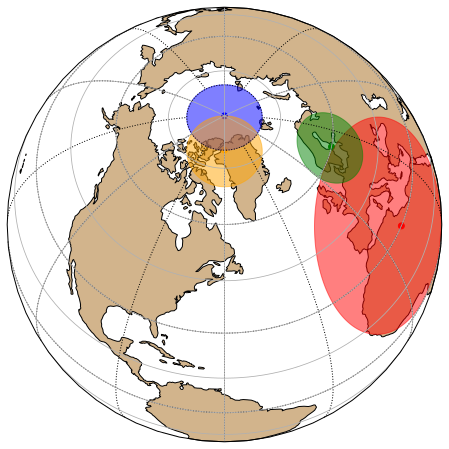

In [9]:
pole1 = Pole( 10., 30., A95=30.)
pole2 = Pole( 20., 60., A95=10.)
pole3 = Pole( 30., 90., A95=10.)

ax = ipmag.make_orthographic_map(300, 60)
ax.set_global()
ax.gridlines()
pole1.plot(ax, color='r')
pole2.plot(ax, color='g')
pole3.plot(ax, color='b')

pole3.rotate(Pole(30, 0), 10)
# print(pole3._pole)
# print(pole1.longitude)
pole3.plot(ax, color='orange')
plt.show()

In [13]:
Euler_pole1 = EulerPole(0, 90, 1)
# print(Euler_pole1._pole/np.dot(Euler_pole1._pole, Euler_pole1._pole))
print('% .2f' %(Euler_pole1.speed_at_point(Pole( 30., 90., A95=10.))))

 0.00


### Fisher distribution class

In [14]:
@as_op(itypes=[T.dvector, T.dscalar, T.dvector], otypes=[T.dscalar])
def vmf_logp(lon_lat, k, x):

#     if x[1] < -90. or x[1] > 90.:
# #         raise ValueError('input latitude must be within (-90, 90)')
#         return -np.inf
    if k < eps:
        return np.log(1. / 4. / np.pi)
    
    theta = pmag.angle(x, lon_lat)[0]
    PdA = k*np.exp(k*np.cos(theta*d2r))/(2*np.pi*(np.exp(k)-np.exp(-k)))
    logp = np.log(PdA)

    return np.array(logp)


class VMF(Continuous):
    def __init__(self, lon_lat=[0,0], k=None, dtype = np.float64,
                 *args, **kwargs):
        super(VMF, self).__init__(*args, **kwargs)
        
        self._k = T.as_tensor_variable(floatX(k))
        self._lon_lat = T.as_tensor_variable(lon_lat)
    
    def logp(self, value):
        lon_lat = self._lon_lat
        k = self._k
        value = T.as_tensor(value)   

        return vmf_logp(lon_lat, k, value)
    
    
    def _random(self, lon_lat, k, size = None):

        alpha = 0.
        beta = np.pi / 2. - lon_lat[1] * d2r
        gamma = lon_lat[0] * d2r

        rotation_matrix = construct_euler_rotation_matrix(alpha, beta, gamma)

        lamda = np.exp(-2*k)

        r1 = np.random.random()
        r2 = np.random.random()
        colat = 2*np.arcsin(np.sqrt(-np.log(r1*(1-lamda)+lamda)/2/k))
        this_lon = 2*np.pi*r2
        lat = 90-colat*r2d
        lon = this_lon*r2d

        unrotated = pmag.dir2cart([lon, lat])[0]
        rotated = np.transpose(np.dot(rotation_matrix, unrotated))
        rotated_dir = pmag.cart2dir(rotated)
        return np.array([rotated_dir[0], rotated_dir[1]])
    
    def random(self, point=None, size=None):
        
        lon_lat, k = draw_values([self._lon_lat, self._k], point=point, size=size)
        return generate_samples(self._random, lon_lat, k,
                                dist_shape=self.shape,
                                size=size)

### random draw fisher distributions

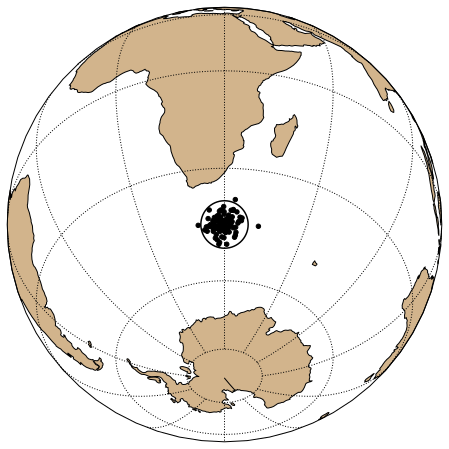

In [17]:
with pm.Model() as model:
    lon = 30.
    lat = -45.
    k = 500.
    vmf = VMF('vmf', lon_lat = [lon, lat], k = k, testval = np.array([1., 0.]), shape = 2)
    data = np.array([vmf.random() for i in range(100)])
    
    phi = data[:,0]
    theta = data[:,1]

    ax = ipmag.make_orthographic_map(lon, lat)
    ipmag.plot_vgp(ax, phi, theta)
    ipmag.plot_pole(ax, lon, lat, two_sigma_from_kappa(k))
    plt.show() 

In [11]:
def fisher_distribution_PdA(k, theta): 
    # take in degrees
    # this function tells you that the fisherian distribution of the declination is uniform
#     PdA = k*np.exp(k*np.cos(theta/180*np.pi))/(4*np.pi*np.sinh(k))
    PdA = k*np.exp(k*np.cos(theta/180*np.pi))/(2*np.pi*(np.exp(k)-np.exp(-k)))
    return PdA

def fisher_distribution_Pdtheta(k, theta):
    if (theta.any() < 0) or (theta.any() > 180):
        raise ZeroProbability
        return -np.inf
    # take in degrees
    # this function is the one which tells you the distribution of the inclination.latitude probability.
    PdA = k*np.exp(k*np.cos(theta/180*np.pi))/(2*np.pi*(np.exp(k)-np.exp(-k)))*np.sin(theta/180*np.pi)
    return PdA

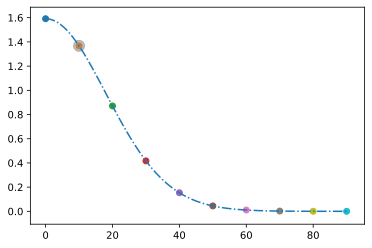

In [12]:
x = [[0, 90], [0, 80], [0, 70], [0, 60], [0, 50], [0, 40], [0, 30], [0, 20], [0, 10], [0, 0]]
lon_lat = [0, 90]
k = 10.
logp_list = list()
for i in range(len(x)):
    logp_list.append(vmf_logp(floatX(T.as_tensor_variable(lon_lat)), T.as_tensor_variable(floatX(k)), floatX(T.as_tensor_variable(x[i]))).tag.test_value)

# print(logp_list)
for i in range (len(x)):
    plt.scatter(i*10, np.exp(logp_list[i]))

theta = np.linspace(0, 90, 100)
k_PdA = fisher_distribution_PdA(k, theta)
plt.plot(theta, k_PdA, '-.', color = 'C0', label = 'k = 10')

y = [0, 80]
angle = pmag.angle(y, lon_lat)
# print(angle)
plt.scatter(angle, fisher_distribution_PdA(k, angle), 120,  color = 'grey', alpha = 0.5)

plt.show()

### Test fisher pole inversion

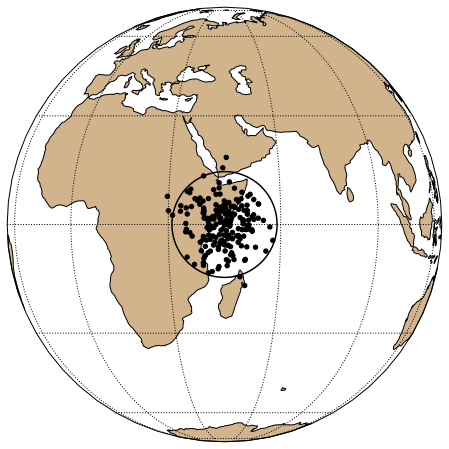

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [lonlat]
>Metropolis: [kappa]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [01:42<00:00, 29.21draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [18]:
theano.config.floatX = 'float64'
lat_hidden = 0.
lon_hidden = 45.
kappa_hidden = 100.

with pm.Model() as model1:
    vmf = VMF('vmf', lon_lat = [lon_hidden, lat_hidden], k = kappa_hidden, testval = np.array([1., 0.]), shape = 2)
    data = np.array([vmf.random() for i in range(200)])
    
with pm.Model() as model2:

#     theano_sparse_data = theano.sparse.as_sparse_variable(data)  
    
    phi = np.array(data)[:,0]
    theta = np.array(data)[:,1]

    ax = ipmag.make_orthographic_map(lon_hidden, lat_hidden)
    ipmag.plot_vgp(ax, phi, theta)
    ipmag.plot_pole(ax, lon_hidden, lat_hidden, two_sigma_from_kappa(kappa_hidden))
    plt.show()
    
    kappa = pm.Exponential('kappa', 1.)
    lon = 1.
    lat = 1.
    k = 1.
    lonlat = VMF('lonlat', lon_lat = [lon, lat], k = k, testval = np.array([1., 0.]), shape = 2)
#     pm.DensityDist('directions', vmf.logp(lon_lat, kappa), observed = {'x':data})
    for i in range(len(data)):
        direction = VMF('direction_'+str(i), lon_lat=lonlat, k=kappa, observed = np.array(data[i]))
    # for testing, here I am turning off the compute covergence checks function
    trace = pm.sample(1000, cores=2, step = pm.Metropolis(), compute_convergence_checks=False)

In [19]:
trace_dataframe = pm.trace_to_dataframe(trace)
trace_1 = pm.save_trace(trace)

In [20]:
trace_dataframe.head()

lonlat__0  lonlat__1      kappa
0  44.350230  -0.020370  65.569242
1  44.736702  -0.159107  65.569242
2  44.398768  -0.730206  65.569242
3  45.206464  -0.687394  64.749137
4  45.206464  -0.687394  64.749137

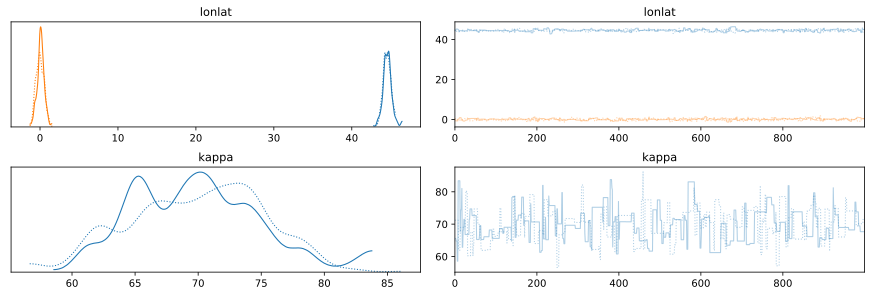

In [21]:
pm.traceplot(trace, ['lonlat', 'kappa']);

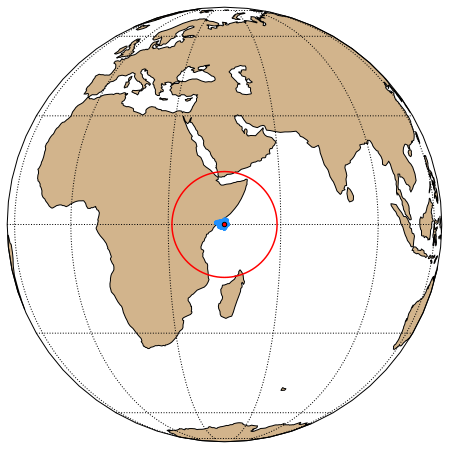

In [26]:
# print(trace.__dict__)
kappa_trace = trace.kappa
lon_lat_trace = trace.lonlat[:1000]
# print(lon_lat_trace)
ax = ipmag.make_orthographic_map(lon_hidden, lat_hidden)
ipmag.plot_vgp(ax, di_block = list(lon_lat_trace[:500]), color = 'dodgerblue', edge = 'none')
ipmag.plot_pole(ax, lon_hidden, lat_hidden, two_sigma_from_kappa(kappa_hidden), color = 'red')
plt.show() 

### Watson girdle class


In [ ]:
# here we compare the log distribution of watson girdle between I. Rose's implementation and the one above
def rose_watson_girdle_logp(x, lon_lat, kappa):

    if x[1] < -90. or x[1] > 90.:
        raise ValueError('input latitude value out of bound')
        return -np.inf

    if np.abs(kappa) < eps:
        return np.log(1. / 4. / np.pi)

    mu = np.array([np.cos(lon_lat[1] * d2r) * np.cos(lon_lat[0] * d2r),
                   np.cos(lon_lat[1] * d2r) * np.sin(lon_lat[0] * d2r),
                   np.sin(lon_lat[1] * d2r)])
    test_point = np.transpose(np.array([np.cos(x[1] * d2r) * np.cos(x[0] * d2r),
                                        np.cos(x[1] * d2r) * np.sin(x[0] * d2r),
                                        np.sin(x[1] * d2r)]))

    normalization = 1. / sc.hyp1f1(0.5, 1.5, kappa) / 4. / np.pi
    logp_elem = np.log( normalization ) + \
        kappa * (np.dot(test_point, mu)**2.)

    logp = logp_elem.sum()
    return logp


In [8]:
@as_op(itypes=[T.dvector, T.dscalar, T.dvector], otypes=[T.dscalar])
def watson_girdle_logp(lon_lat, k, x):
    
    if k > 0:
        raise ValueError('k has to be negative!')
        return 
    
    theta = pmag.angle(x, lon_lat)[0]
    pw = 1/sc.hyp1f1(1/2, 3/2, k)/4/np.pi*np.exp(k*np.cos(theta*d2r)**2)
    log_pw = np.log(pw)
    
    return np.array(log_pw)


class Watson_Girdle(Continuous):
    def __init__(self, lon_lat=[0,0], k=None, dtype = np.float64, 
                 *args, **kwargs):
        super(Watson_Girdle, self).__init__(*args, **kwargs)
        
        self._lon_lat = T.as_tensor(lon_lat)
        self._k = T.as_tensor_variable(floatX(k))
    
    def logp(self, value):
        lon_lat = self._lon_lat
        k = self._k
        value = T.as_tensor(value)
        
        return watson_girdle_logp(lon_lat, k, value)
    
    def _random(self, lon_lat, k, size = None):
        
        beta = np.pi / 2. - lon_lat[1] * d2r
        gamma = lon_lat[0] * d2r
        rotation_matrix = construct_euler_rotation_matrix(0, beta, gamma)

        C1 = np.sqrt(abs(k))
        C2 = np.arctan(C1)

        this_lon = 0
        this_lat = 0

        i = 0
        while i < 1:
            U = np.random.random()
            V = np.random.random()
            S = 1/C1*np.tan(C2*U)
            r0 = np.random.random()

            if V < (1-k*S**2)*np.exp(k*S**2):
                this_lon = 0
                this_lat = 0
                pos_neg = 0
                colat = np.arccos(S)
                this_lon = 2*np.pi*r0
                pos_neg = random.choice([-1, 1])
                this_lon = this_lon*r2d
                this_lat = pos_neg*(90-colat*r2d)
                i = i + 1

        x = np.cos(this_lon*d2r)*np.cos(this_lat*d2r)
        y = np.sin(this_lon*d2r)*np.cos(this_lat*d2r)
        z = np.sin(this_lat*d2r)

        unrotated_samples = np.array([x, y, z])
        s = np.transpose(np.dot(rotation_matrix, unrotated_samples))

        lon_lat = np.array([np.arctan2(s[1], s[0]), np.pi /
                            2. - np.arccos(s[2] / np.sqrt(np.dot(s, s)))]) * r2d
#         print(lon_lat)
        return lon_lat
    
    def random(self, point=None, size=None):
        lon_lat = self._lon_lat
        k = self._k
        
        lon_lat, k = draw_values([self._lon_lat, self._k], point=point, size=size)
        return generate_samples(self._random, lon_lat, k,
                                dist_shape=self.shape,
                                size=size)
    

In [ ]:
with pm.Model() as model:
    lon = 30.
    lat = 30.
    k = -100.
    WG = Watson_Girdle('WG', lon_lat = [lon, lat], k = k, testval = np.array([1., 0.]), shape = 2)
    data = np.array([WG.random() for i in range(500)])
    
    phi = data[:,0]
    theta = data[:,1]

    ax = ipmag.make_orthographic_map(lon, lat-90)
    ipmag.plot_vgp(ax, phi, theta)
    plt.show() 

In [ ]:
with pm.Model() as model:
    WG = Watson_Girdle('WG', lon_lat = np.array([1., 0.]), k = -1., observed = [0,0])

In [ ]:
def watson_girdle_pdf(kw, theta):
    pw = 1/sc.hyp1f1(1/2, 3/2, kw)/4/np.pi*np.exp(kw*np.cos(theta/180*np.pi)*np.cos(theta/180*np.pi))
    
    return pw

In [ ]:
x = [[0, -90],[0, -80], [0, -70], [0, -60], [0, -50], [0, -40], [0, -30], [0, -20], [0, -10], [0, 0], 
     [0, 10] , [0, 20], [0, 30], [0, 40], [0, 50], [0, 60], [0, 70], [0, 80], [0, 90]]
lon_lat = [0, 90]
k = -10

# I. Rose calculation for pdf
logp_list = list()
for i in range(len(x)):
    logp_list.append(watson_girdle_logp(floatX(T.as_tensor_variable(lon_lat)), T.as_tensor_variable(floatX(k)), floatX(T.as_tensor_variable(x[i]))).tag.test_value)
#     logp_list.append(rose_watson_girdle_logp(x[i], lon_lat, k))
for i in range (len(x)):
    plt.scatter((180-i*10)*d2r, np.exp(logp_list[i]))

# this calculation for pdf
theta = np.linspace(0, 180, num = 100)
pw = watson_girdle_pdf(k, theta)
plt.plot(theta*d2r, pw, color = 'C0', label = 'kw = ' + str(k))


plt.title('watson girdle distribution')
# plt.legend()
plt.show()

### Test watson girdle inversion

In [ ]:
theano.config.floatX = 'float64'
lat_hidden = 30.
lon_hidden = 30.
kappa_hidden = -50.

with pm.Model() as model1:
    WG = Watson_Girdle('WG', lon_lat = [lon_hidden, lat_hidden], k = kappa_hidden, testval = np.array([1., 0.]), shape = 2)
    data = np.array([WG.random() for i in range(200)])
    
with pm.Model() as model2:

#     theano_sparse_data = theano.sparse.as_sparse_variable(data)  
    
    phi = np.array(data)[:,0]
    theta = np.array(data)[:,1]

    ax = ipmag.make_orthographic_map(lon_hidden, lat_hidden)
    ipmag.plot_vgp(ax, phi, theta)
    plt.show()
    
    kappa = -pm.Exponential('kappa', 1.)
    lon = 1.
    lat = 1.
    k = -1.
    lonlat = Watson_Girdle('lonlat', lon_lat = [lon, lat], k = k, testval = np.array([1., 0.]), shape = 2)
#     pm.DensityDist('directions', vmf.logp(lon_lat, kappa), observed = {'x':data})
    for i in range(len(data)):
        direction = Watson_Girdle('direction_'+str(i), lon_lat=lonlat, k=kappa, observed = np.array(data[i]))

    trace = pm.sample(1000, step = pm.Metropolis())

In [ ]:
trace_dataframe = pm.trace_to_dataframe(trace)
trace_dataframe

In [ ]:
pm.traceplot(trace, ['lonlat', 'kappa'])

In [ ]:
# print(trace.__dict__)
kappa_trace = trace.kappa
lon_lat_trace = trace.lonlat[:1000]
# print(lon_lat_trace)

ax = ipmag.make_orthographic_map(lon_hidden, lat_hidden)
ipmag.plot_vgp(ax, di_block = list(lon_lat_trace), color = 'dodgerblue', edge = 'none')
ipmag.plot_pole(ax, lon_hidden, lat_hidden, 140/np.sqrt(abs(kappa_hidden)), color = 'red')
plt.show() 

## Test euler pole inversion

In [27]:
@as_op(itypes=[T.dvector, T.dvector, T.dscalar, T.dvector, T.dscalar,  T.dscalar,  T.dscalar], otypes=[T.dvector])
def pole_position( start, euler_1, rate_1, euler_2, rate_2, switchpoint, time ):

    euler_pole_1 = EulerPole( euler_1[0], euler_1[1], rate_1)
    euler_pole_2 = EulerPole( euler_2[0], euler_2[1], rate_2)
    start_pole = PaleomagneticPole(start[0], start[1], age=time)

    if time <= switchpoint:
        start_pole.rotate( euler_pole_1, euler_pole_1.rate*time)
    else:
        start_pole.rotate( euler_pole_1, euler_pole_1.rate*switchpoint)
        start_pole.rotate( euler_pole_2, euler_pole_2.rate*(time-switchpoint))

    lon_lat = np.array([start_pole.longitude, start_pole.latitude])

    return lon_lat

@as_op(itypes=[T.dvector, T.dvector, T.dscalar, T.dscalar], otypes=[T.dvector])
def pole_position_1e( start, euler_1, rate_1, age ):

    euler_pole_1 = EulerPole( euler_1[0], euler_1[1], rate_1)
    start_pole = PaleomagneticPole(start[0], start[1], age=age)

    start_pole.rotate(euler_pole_1, euler_pole_1.rate*age)

    lon_lat = np.array([start_pole.longitude, start_pole.latitude])

    return lon_lat

In [30]:
# Generate a synthetic data set
ages =[0.,10.,20.,30.,40]
sigma_ages = np.array([2., 2., 2., 2., 2.])
age_taus = 1./(sigma_ages*sigma_ages)
lon_lats = [[300., 30.], [330., 30.], [0., 30.], [30., 30.], [60., 30.]]

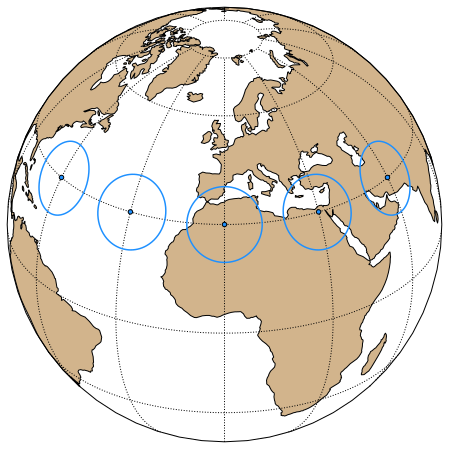

In [31]:
ax = ipmag.make_orthographic_map(0., 30.)
for lon_lat in lon_lats:
    
    ipmag.plot_pole(ax, lon_lat[0], lon_lat[1], 10, color = 'dodgerblue')
plt.show() 

In [32]:
theano.config.floatX = 'float64'

with pm.Model() as model:

    euler_1 = VMF('euler_1', lon_lat = [1.,0.,], k = 1., testval = np.array([1., 0.]), shape = 2)
    rate_1 = pm.Exponential('rate_1', 1.) 
    
    start = VMF('start', lon_lat=lon_lats[0], k = kappa_from_two_sigma(10.), testval = np.array([1., 0.]), shape = 2)


    for i in range(len(ages)):
        time = pm.Normal('t'+str(i), mu=ages[i], tau=sigma_ages[i])
#         lon_lat = pm.DensityDist('ll'+str(i), lambda placehoder = 0., st=start, e1=euler_1, r1=rate_1, e2=euler_2, r2=rate_2, sw=switchpoint, t=time : pole_position(st, e1, r1, e2, r2, sw, t))
        lon_lat = pole_position_1e(start, euler_1, rate_1, time )

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(10.), observed=lon_lats[i])
    trace = pm.sample(1000, step = pm.Metropolis(), compute_convergence_checks=False, cores=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [t4]
>Metropolis: [t3]
>Metropolis: [t2]
>Metropolis: [t1]
>Metropolis: [t0]
>Metropolis: [start]
>Metropolis: [rate_1]
>Metropolis: [euler_1]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:41<00:00, 72.02draws/s]


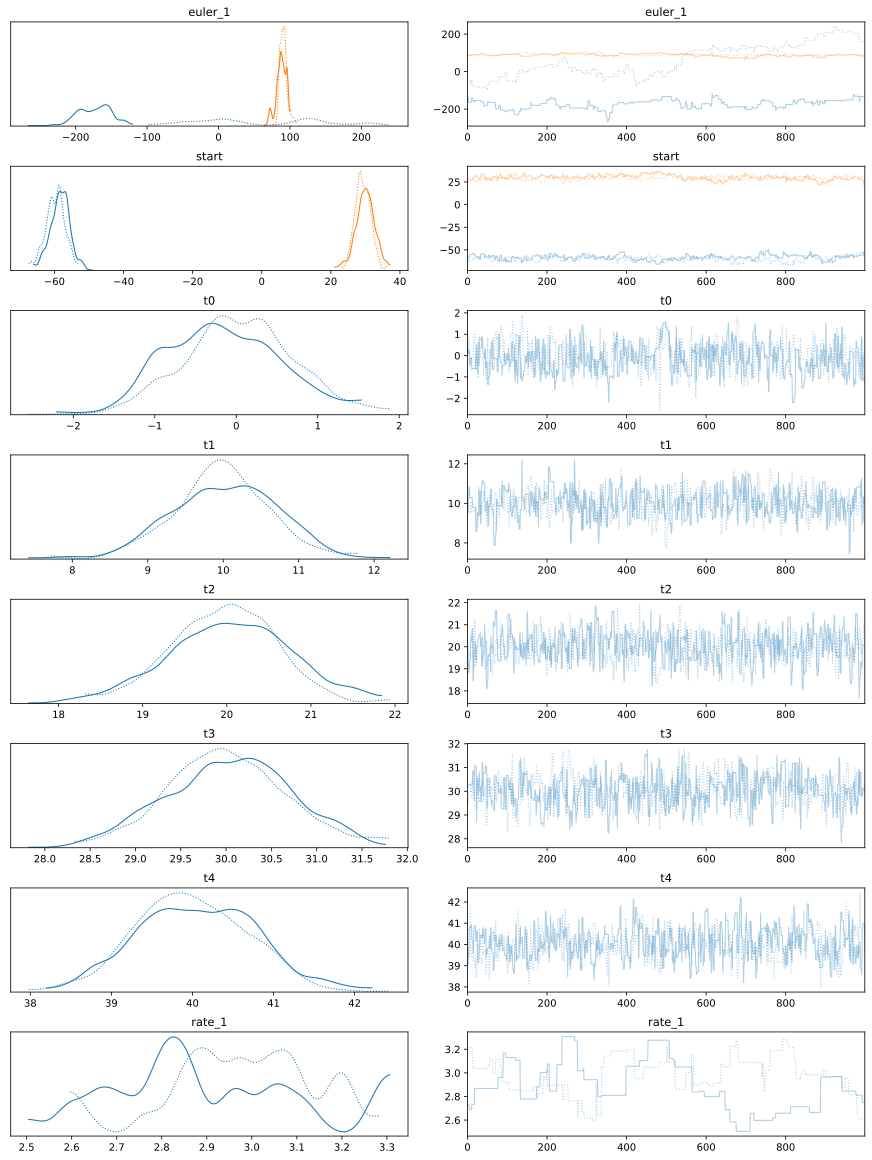

In [33]:
pm.traceplot(trace);

In [43]:
def plot_trace( trace, central_lon = 30., central_lat = 30., num_points_to_plot = 500, num_paths_to_plot = 500, savefig = False ):
    def pole_position( start, euler_1, rate_1, euler_2, rate_2, switchpoint, time ):

        euler_pole_1 = EulerPole( euler_1[0], euler_1[1], rate_1)
        euler_pole_2 = EulerPole( euler_2[0], euler_2[1], rate_2)
        start_pole = PaleomagneticPole(start[0], start[1], age=time)

        if time <= switchpoint:
            start_pole.rotate( euler_pole_1, euler_pole_1.rate*time)
        else:
            start_pole.rotate( euler_pole_1, euler_pole_1.rate*switchpoint)
            start_pole.rotate( euler_pole_2, euler_pole_2.rate*(time-switchpoint))

        lon_lat = np.array([start_pole.longitude, start_pole.latitude])

        return lon_lat
    
    euler_1_directions = trace.euler_1
    rates_1 = trace.rate_1

    euler_2_directions = trace.euler_2
    rates_2 = trace.rate_2

    start_directions = trace.start
    switchpoints = trace.switchpoint

    interval = max([1,int(len(rates_1)/num_paths_to_plot)])

    #ax = plt.axes(projection = ccrs.Orthographic(0.,30.))
    ax = ipmag.make_orthographic_map(central_lon, central_lat)
    
    ipmag.plot_vgp( ax, euler_1_directions[:,0][:num_points_to_plot], euler_1_directions[:,1][:num_points_to_plot])
    ipmag.plot_vgp( ax, euler_2_directions[:,0][:num_points_to_plot], euler_2_directions[:,1][:num_points_to_plot])

    age_list = np.linspace(ages[0], ages[-1], num_paths_to_plot)
    pathlons = np.empty_like(age_list)
    pathlats = np.empty_like(age_list)
    for start, e1, r1, e2, r2, switch \
                 in zip(start_directions[::interval], 
                        euler_1_directions[::interval], rates_1[::interval],
                        euler_2_directions[::interval], rates_2[::interval],
                        switchpoints[::interval]):
        for i,a in enumerate(age_list):
            lon_lat = pole_position( start, e1, r1, e2, r2, switch, a)
            pathlons[i] = lon_lat[0]
            pathlats[i] = lon_lat[1]

        ax.plot(pathlons,pathlats,color='b', transform=ccrs.Geodetic(), alpha=0.05)
    for p in lon_lats:
        pole = PaleomagneticPole( p[0], p[1], A95=10. )
        pole.plot(ax)
    if savefig == True:
        plt.savefig('Euler_inversion_test.pdf')
    plt.show()
    
def plot_trace_1e( trace, central_lon = 30., central_lat = 30., num_points_to_plot = 200, num_paths_to_plot = 200, savefig = False, figname = 'Figures/1_Euler_inversion_test.pdf'):
    def pole_position( start, euler_1, rate_1, time ):

        euler_pole_1 = EulerPole( euler_1[0], euler_1[1], rate_1)
        start_pole = PaleomagneticPole(start[0], start[1], age=time)

        start_pole.rotate( euler_pole_1, euler_pole_1.rate*time)

        lon_lat = np.array([start_pole.longitude, start_pole.latitude])

        return lon_lat
    
    euler_1_directions = trace.euler_1
    rates_1 = trace.rate_1

    start_directions = trace.start

    interval = max([1,int(len(rates_1)/num_paths_to_plot)])

    ax = ipmag.make_orthographic_map(central_lon, central_lat)
    
    ax.scatter(euler_1_directions[:,0][:num_points_to_plot], euler_1_directions[:,1][:num_points_to_plot], transform=ccrs.Geodetic(), marker = 's', color='b', alpha=0.1)

    age_list = np.linspace(ages[0], ages[-1], num_paths_to_plot)
    pathlons = np.empty_like(age_list)
    pathlats = np.empty_like(age_list)
    for start, e1, r1 in zip(start_directions[::interval], 
                        euler_1_directions[::interval], rates_1[::interval]):
        for i,a in enumerate(age_list):
            lon_lat = pole_position( start, e1, r1, a)
            pathlons[i] = lon_lat[0]
            pathlats[i] = lon_lat[1]

        ax.plot(pathlons,pathlats,color='b', transform=ccrs.Geodetic(), alpha=0.05)
    for p in lon_lats:
        pole = PaleomagneticPole( p[0], p[1], A95=5. )
        pole.plot(ax)
    if savefig == True:
        plt.savefig(figname)
    plt.show()

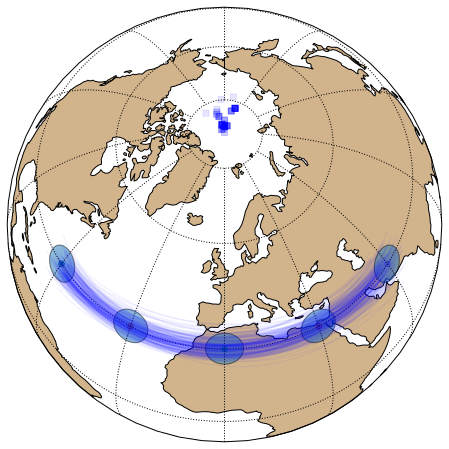

In [44]:
plot_trace_1e(trace, 0, 65, 200, 200, savefig = False)

In [ ]:
with pm.Model() as model:

    euler_1 = VMF('euler_1', lon_lat = [1.,0.,], k = 1., testval = np.array([1., 0.]), shape = 2)
    rate_1 = pm.Exponential('rate_1', 1.) 
    euler_2 = VMF('euler_2', lon_lat = [1.,0.,], k = 1., testval = np.array([1., 0.]), shape = 2)
    rate_2 = pm.Exponential('rate_2', 1.) 
    
    start = VMF('start', lon_lat=lon_lats[0], k = kappa_from_two_sigma(10.), testval = np.array([1., 0.]), shape = 2)
    
    switchpoint = pm.Uniform('switchpoint', ages[0], ages[-1])


    for i in range(len(ages)):
        time = pm.Normal('t'+str(i), mu=ages[i], tau=age_taus[i])
#         lon_lat = pm.DensityDist('ll'+str(i), lambda placehoder = 0., st=start, e1=euler_1, r1=rate_1, e2=euler_2, r2=rate_2, sw=switchpoint, t=time : pole_position(st, e1, r1, e2, r2, sw, t))
        lon_lat = pole_position(start, euler_1, rate_1, euler_2, rate_2, switchpoint, time )

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(10.), observed=lon_lats[i])
    trace = pm.sample(1000, step = pm.Metropolis(), compute_convergence_checks=False, cores=2)

In [ ]:
trace_dataframe = pm.trace_to_dataframe(trace)
trace_dataframe

In [ ]:
pm.traceplot(trace, ['euler_1', 'euler_2', 'rate_1', 'rate_2', 'start', 'switchpoint', 't0', 't1', 't2', 't3', 't4'])
plt.show()

### APWP class

In [64]:
theano.config.floatX = 'float64'
def create_model(name = None, 
                 paleomagnetic_pole_list = None, 
                 A95_list = None,
                 age_list = None, 
                 age_uncertainty_list = None,
                 age_uncertainty_type_list = None,
                 n_euler_poles=0, 
                 include_tpw = False, 
                 site_lon_lat=[1., 0.], 
                 k=1., 
                 kw = -1., 
                 euler_rate=1., 
                 tpw_pole_angle = None,
                 tpw_rate_scale = None, 
                 sample_size = 2000):
    
    assert name != None, "must have a model name"
    assert paleomagnetic_pole_list != None, "must have a paleomagnetic pole list"
    assert A95_list != None, "must have a A95 list"
    assert age_list != None, "must have an age list"
    assert age_uncertainty_list != None, "must have an age uncertainty list"
    assert age_uncertainty_type_list != None, "must have an age uncertainty type list"
    assert n_euler_poles >= 0 , "must have a nonnegative euler pole number"
    
    assert euler_rate > 0.0, "rate_scale must be a positive number."
    assert tpw_pole_angle == None or tpw_rate_scale > 0.0, "true polar wander angle must be nonnegative"
    assert tpw_rate_scale == None or tpw_rate_scale > 0.0, "true polar wander rate must be nonnegative"
    assert kw <= 0.0, "nonnegative Watson concentration parameters are not supported"
    
    start_age = max(age_list)
    start_pole = paleomagnetic_pole_list[np.argmax(age_list)]
    start_A95 = A95_list[np.argmax(age_list)]
    
    if tpw_rate_scale is None:
        include_tpw = False
    else:
        include_tpw = True
    

    def pole_position(start, start_age, this_age, euler_list, rate_list, changepoint_list, tpw_pole_angle=0., tpw_rate=0.):
#         if len(args) != max( (n_euler_poles * 3 - 1), 0):
#             raise Exception("Unexpected number of euler poles/changepoints: expected %i, got %i"%(n_euler_poles*3-1, len(args)))
  
        @as_op(itypes=[T.dvector], otypes=[T.dvector])
        def get_pole_position(start):
            changepoint_list = np.sort(changepoint_list)[::-1]

            # make a starting pole
            start_pole = [start[0], start[1]]
            start_pole_cart = spherical_to_cartesian(start[0], start[1])

            # make a TPW pole
            test_1 = np.array([0.,0.,1.])
            test_2 = np.array([1.,0.,0.])

            # determine which side the tpw pole is on the globe
    #         if np.dot(start_pole_cart, test_1) > np.dot(start_pole_cart, test_2):
            if T.gt(np.dot(start_pole_cart, test_1), np.dot(start_pole_cart, test_2)):
                tpw_pole = np.cross(start_pole_cart, test_2) # tpw pole in cartesian coordinates
            else:
                tpw_pole = np.cross(start_pole_cart, test_1) # tpw pole in cartesian coordinates

    #         print(start_pole_cart, tpw_pole, tpw_pole_angle)
    #         tpw = rotate(start_pole_cart, tpw_pole, tpw_pole_angle)      # amount of tpw in cartesian coordinates

            if n_euler_poles == 0:
                this_pole = rotate(start_pole_cart, tpw_pole, tpw_rate * (start_age-this_age))
            else:
                this_pole = start_pole_cart
                for e, c in zip(euler_list, changepoint_list):
                    # add tpw contribution

                    this_euler = spherical_to_cartesian(e[0], e[1]) + tpw # cartesian coordinates current euler pole plus tpw

                    if this_age < c:
                        angle = tpw_rate * (start_age - c)
                        this_pole = rotate(this_pole, this_euler, angle)
                        this_age = c
                    else:
                        angle = tpw_rate * (start_age - this_age)
                        this_pole = rotate(this_pole, this_euler, angle)
                        break

            lon, lat, _ = cartesian_to_spherical(this_pole)
            return np.array([lon[0], lat[0]])
        
        lon_lat = get_pole_position
        return lon_lat
        
    with pm.Model() as APWP_model:   
        start = VMF('start', 
                    lon_lat = start_pole, 
                    k = kappa_from_two_sigma(start_A95), 
                    testval = np.array([1., 0.]), shape = 2)
        
        euler_list = []
        rate_list = []
        changepoint_list = []
        
        # set up true polar wander variable if necessary
        if include_tpw:
            tpw_pole_angle = pm.Uniform('tpw_pole_angle', 0., 360., testval=0., observed=False)
            tpw_rate = pm.Exponential('tpw_rate', tpw_rate_scale)

        # Make Euler pole direction random variables
        for i in range(n_euler_poles):
            euler = VMF('euler_' + str(i), lon_lat=site_lon_lat, k=k, testval=np.array([1.,0.]), shape = 2)
            euler_list.append(euler)
            
        # Make Euler pole rate random variables
        for i in range(n_euler_poles):
            rate = pm.Exponential('rate_' + str(i), euler_rate)
            rate_list.append(rate)
            
        # Make changepoint random variables
        for i in range(n_euler_poles - 1):
            changepoint = pm.Uniform('changepoint_' + str(i),lower = min(age_list), upper = max(age_list))
            changepoint_list.append(changepoint)
            
        for i, (this_pole, this_A95, this_age, this_age_uncertainty, this_uncertainty_type) in enumerate(
            zip(paleomagnetic_pole_list, A95_list, age_list, age_uncertainty_list, age_uncertainty_type_list)):
                

            if this_uncertainty_type == 'gaussian':
                pole_age = pm.Normal('a_' + str(i), mu=this_age, sd = this_age_uncertainty/2)
            elif this_uncertainty_type == 'uniform':
                pole_age = pm.Uniform('a_' + str(i), lower=this_age_uncertainty[0], upper=this_age_uncertainty[1])

            if include_tpw:
                
                lon_lat = pole_position(start, start_age, this_age, euler_list, rate_list, changepoint_list, tpw_pole_angle, tpw_rate)
            else:
                lon_lat = pole_position(start, start_age, this_age, euler_list, rate_list, changepoint_list)
            
            print(lon_lat)
            observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(this_A95), observed=this_pole)
            
        trace = pm.sample(sample_size, step = pm.Metropolis())
        
    return trace


In [65]:
test_pmag_pole_list = [[300., 30.], [330., 30.], [0., 30.], [30., 30.], [60., 30.]]
test_A95_list = [10., 10., 10., 10., 10.]
test_age_list =[0.,10.,20.,30.,40.]
test_age_uncertainty_list = [2., 2., 2., 2., 2.]
test_age_uncertainty_type = ['gaussian', 'gaussian', 'gaussian', 'gaussian', 'gaussian']


test_trace = create_model(name = 'test', 
                 paleomagnetic_pole_list = test_pmag_pole_list, 
                 A95_list = test_A95_list,
                 age_list = test_age_list, 
                 age_uncertainty_list = test_age_uncertainty_list,
                 age_uncertainty_type_list = test_age_uncertainty_type,
                 n_euler_poles=1, 
                 include_tpw = False, 
                 site_lon_lat=[1., 0.], 
                 k=1., 
                 kw = -1., 
                 euler_rate=1., 
                 tpw_pole_angle = None,
                 tpw_rate_scale = None, 
                 sample_size = 2000)


FromFunctionOp{get_pole_position}


AsTensorError: ('Cannot convert FromFunctionOp{get_pole_position} to TensorType', <class 'theano.compile.ops.FromFunctionOp'>)

In [52]:
def cartesian_to_spherical(vecs):
    v = np.reshape(vecs, (3, -1))
    norm = np.sqrt(v[0, :] * v[0, :] + v[1, :] * v[1, :] + v[2, :] * v[2, :])
    latitude = 90. - np.arccos(v[2, :] / norm) * r2d
    longitude = np.arctan(v[1, :]/v[0, :]) * r2d
    v1 = v[1, :]
    v0 = v[0, :]
    for i in range(len(longitude)):
        if T.lt(v1[i], 0) and T.lt(v0[i], 0):
            longitude[i] = longitude[i] + 180
        elif T.gt(v1[i], 0) and T.lt(v0[i], 0):
            longitude[i] = longitude[i] + 180

    return longitude, latitude, norm

In [ ]:
class APWP(object):

    def __init__(self, name, paleomagnetic_pole_list, n_euler_poles, sample_size = 2000):
        for p in paleomagnetic_pole_list:
            assert (isinstance(p, PaleomagneticPole))

        self._name = name
        self._poles = paleomagnetic_pole_list
        self.n_euler_rotations = n_euler_poles

        self._age_list = [p._age for p in self._poles]
        self._start_age = max(self._age_list)
        self._start_pole = self._poles[np.argmax(self._age_list)]
        self._sample_size = sample_size 
    
    def create_model(self, site_lon_lat=[1., 0.], k=1., kw = -1., euler_rate=1., tpw_rate_scale = None):
        assert euler_rate > 0.0, "rate_scale must be a positive number."
        assert tpw_rate_scale == None or tpw_rate_scale > 0.0
        assert kw <= 0.0, "Nonnegative Watson concentration parameters are not supported."
        if tpw_rate_scale is None:
            self.include_tpw = False
        else:
            self.include_tpw = True
            
        with pm.Model() as APWP_model:   
            start = VMF('start', 
                        lon_lat=[self._start_pole.longitude, self._start_pole.latitude], 
                        k=kappa_from_two_sigma(self._start_pole._A95), 
                        testval = np.array([1., 0.]), shape = 2)
            
#             if self.n_euler_rotations == 0 and tpw_rate_scale!= None:
#                 tpw_pole_angle = pm.Uniform('tpw_pole_angle', 0., 360., value=0., observed=False)
#                 tpw_rate = pm.Exponential('tpw_rate', tpw_rate_scale)
                
#             elif self.n_euler_rotations == 1:
#                 euler_1 = VMF('euler_1', lon_lat = [1., 0.], k = k, testval = np.array([1., 0.]), shape = 2)
#                 rate_1 = pm.Exponential('rate_1', euler_rate) 

#                 for i in range(len(self._poles)):
#                     p = self._poles[i]

#                     if p._age_type == 'gaussian':
#                         pole_age = pm.Normal('t'+str(i), mu=self._age_list[i], tau=1/(p._sigma_age**-2))
#                     elif p._age_type == 'uniform':
#                         pole_age = pm.Uniform('t'+str(i), lower=p._sigma_age[0], upper=p._sigma_age[1])

#                     lon_lat = pole_position_1e(start, euler_1, rate_1, pole_age )
#                     observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(p._A95), observed=[p.longitude, p.latitude])
                    
#             elif self.n_euler_rotations == 2:
                
            euler_1 = VMF('euler_1', lon_lat = site_lon_lat, k = k, testval = np.array([1., 0.]), shape = 2)
            rate_1 = pm.Exponential('rate_1', euler_rate) 
            euler_2 = VMF('euler_2', lon_lat = site_lon_lat, k = k, testval = np.array([1., 0.]), shape = 2)
            rate_2 = pm.Exponential('rate_2', euler_rate) 
            switchpoint = pm.Uniform('switchpoint', min(self._age_list), max(self._age_list))
                
            for i in range(len(self._poles)):
                p = self._poles[i]

                if p._age_type == 'gaussian':
                    pole_age = pm.Normal('t'+str(i), mu=self._age_list[i], tau=1/(p._sigma_age**-2))
                elif p._age_type == 'uniform':
                    pole_age = pm.Uniform('t'+str(i), lower=p._sigma_age[0], upper=p._sigma_age[1])

                lon_lat = pole_position(start, euler_1, rate_1, euler_2, rate_2, switchpoint, pole_age )
                observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(p._A95), observed=[p.longitude, p.latitude])
                    
            trace = pm.sample(self._sample_size, step = pm.Metropolis())
#             for i in range(len(self._poles)):
#                 p = self._poles[i]

# #                 time = self._start_age
#                 if p._age_type == 'gaussian':
#                     pole_age = pm.Normal('t'+str(i), mu=self._age_list[i], tau=1/(p._sigma_age**-2))
#                 elif p._age_type == 'uniform':
#                     pole_age = pm.Uniform('t'+str(i), lower=p._sigma_age[0], upper=p._sigma_age[1])

#                 if self.n_euler_rotations == 2:
#                     lon_lat = pole_position(start, eulers[0], rates[0], eulers[1], rates[1], changes[0], pole_age)
#                 lon_lat = pole_position(start, euler_1, rate_1, euler_2, rate_2, switchpoint, pole_age )
#                 observed_pole = VMF('p'+str(i), lon_lat, k=kappa_from_two_sigma(p._A95), observed=[p.longitude, p.latitude])
#                 observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(p._A95), observed=[p.longitude, p.latitude])
#             if self.include_tpw:
#                 tpw_pole_angle = pm.Uniform('tpw_pole_angle', lower = 0., upper = 360.)
#                 tpw_rate = pm.Exponential('tpw_rate', tpw_rate_scale)
                   
        return trace

In [ ]:
theano.config.floatX = 'float64'
# Generate a synthetic data set
ages =[0.,10.,20.,30.,40.]
sigma_ages = [2., 2., 2., 2., 2.]

lonlats = [[300., 30.], [330., 30.], [0., 30.], [30., 30.], [60., 30.]]
# lon_lats = [ [300., -20.], [340.,0.], [0.,30.], [20., 0.], [60.,-20.]]

poles = []
for a, s, ll in zip(ages, sigma_ages, lonlats):
    pole = PaleomagneticPole( ll[0], ll[1], A95=5., age=a, sigma_age=s)
    poles.append(pole)
    
path = APWP('apw', poles, 2)

print(path._name)
print(path._poles)
print(path.n_euler_rotations)
print(path._age_list)
print(path._start_age)
print(path._start_pole)

trace = path.create_model()

In [ ]:
theano.config.floatX = 'float64'
# Generate a synthetic data set
ages =[0.,10.,20.,30.,40.]
sigma_ages = [2., 2., 2., 2., 2.]

lon_lats = [[300., 30.], [330., 30.], [0., 30.], [30., 30.], [60., 30.]]
with pm.Model() as model:

    euler_1 = VMF('euler_1', lon_lat = [1.,0.,], k = 1., testval = np.array([1., 0.]), shape = 2)
    rate_1 = pm.Exponential('rate_1', 1.) 
    
    start = VMF('start', lon_lat=lon_lats[0], k = kappa_from_two_sigma(10.), testval = np.array([1., 0.]), shape = 2)


    for i in range(len(ages)):
        time = pm.Normal('t'+str(i), mu=ages[i], tau=sigma_ages[i])
#         lon_lat = pm.DensityDist('ll'+str(i), lambda placehoder = 0., st=start, e1=euler_1, r1=rate_1, e2=euler_2, r2=rate_2, sw=switchpoint, t=time : pole_position(st, e1, r1, e2, r2, sw, t))
        lon_lat = pole_position_1e(start, euler_1, rate_1, time )

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(10.), observed=lon_lats[i])
    trace = pm.sample(2500, step = pm.Metropolis())

In [ ]:
pm.traceplot(trace, [ 'start', 'euler_1', 'rate_1', 't0', 't1', 't2', 't3', 't4'])
plt.show()

In [ ]:
plot_trace_1e(trace, 0, 20, 200, 200, savefig = True, figname = '1_euler_inversion_example.pdf')

In [ ]:
theano.config.floatX = 'float64'
# Generate a synthetic data set
ages =[0.,10.,20.,30.,40.]
sigma_ages = [2., 2., 2., 2., 2.]

lon_lats = [ [300., -20.], [340.,0.], [0.,30.], [20., 0.], [60.,-20.]]

poles = []
for a, s, ll in zip(ages, sigma_ages, lon_lats):
    pole = PaleomagneticPole( ll[0], ll[1], A95=10., age=a, sigma_age=s)
    poles.append(pole)
    
path = APWP('apw', poles, 2)

print(path._name)
print(path._poles)
print(path.n_euler_rotations)
print(path._age_list)
print(path._start_age)
print(path._start_pole)

trace = path.create_model()


In [ ]:
pm.traceplot(trace, ['euler_1', 'euler_2', 'rate_1', 'rate_2', 'start', 'switchpoint', 't0', 't1', 't2', 't3', 't4'])
plt.show()

# Loading Jurassic Monster Shift poles and do Euler inversion

In [ ]:
Monster_poles = pd.read_csv('2020_Jurassic_Monster_Shift/pmag_compiled/compiled_monster_poles.csv')
Monster_poles = Monster_poles.sort_values(by = 'AgeNominal')
Monster_poles

In [ ]:
ages_ = Monster_poles['AgeNominal'].tolist()
ages_ = [round(ages_[i]-min(ages_), 1) for i in range(len(ages_))]
sigma_ages_ = Monster_poles['Gaussian_2sigma'].tolist()

lons = Monster_poles['PLon'].tolist()
lats = Monster_poles['PLat'].tolist()
lonlats = [[lons[i], lats[i]] for i in range(len(lons))]
A95_list_ = Monster_poles['A95'].tolist()

print(ages_)
print(sigma_ages_)
print(lonlats)
print(A95_list_)

In [ ]:
map_axis = ipmag.make_orthographic_map(150, 65)
ipmag.plot_poles(map_axis, lons, lats, A95_list_)
plt.show()

In [ ]:
theano.config.floatX = 'float64'

with pm.Model() as model:

    euler_1 = VMF('euler_1', lon_lat = [1.,1.], k = 1., testval = np.array([1., 1.]), shape = 2)
    rate_1 = pm.Exponential('rate_1', 2.) 
    
    start = VMF('start', lon_lat=[1.,1.], k = 1., testval = np.array([1., 1.]), shape = 2)

    for i in range(len(ages_)):
        time = pm.Normal('t'+str(i), mu=ages_[i], tau=sigma_ages_[i])
        lon_lat = pole_position_1e(start, euler_1, rate_1, time )

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(A95_list_[i]), observed=lonlats[i])
    trace = pm.sample(2000, step = pm.Metropolis())

In [ ]:
trace_dataframe = pm.trace_to_dataframe(trace)
trace_dataframe

In [ ]:
plot_trace_1e(trace, 150, 65, 200, 200, savefig = False, figname = '1_euler_inversion_Monster_Shift.pdf')

In [ ]:
theano.config.floatX = 'float64'
# Generate a synthetic data set
ages =[0.0, 12.9, 15.5, 27.0]
sigma_ages = [4.0, 1.1, 1.2, 8.0]
# sigma_ages = [2., 2., 2., 2., 2.]
lon_lats = [[203.1, 58.1], [184.1, 73.5], [198.9, 77.9], [90.3, 78.7]]

angular_errors = [3.8, 3.7, 4.1, 7.4]

with pm.Model() as model:

    euler_1 = VMF('euler_1', lon_lat = [1.,0.,], k = 1., testval = np.array([1., 0.]), shape = 2)
    rate_1 = pm.Exponential('rate_1', 1.) 
    
    start = VMF('start', lon_lat=lon_lats[0], k = kappa_from_two_sigma(5.), testval = np.array([1., 0.]), shape = 2)


    for i in range(len(ages)):
        time = pm.Normal('t'+str(i), mu=ages[i], tau=sigma_ages[i])
#         lon_lat = pm.DensityDist('ll'+str(i), lambda placehoder = 0., st=start, e1=euler_1, r1=rate_1, e2=euler_2, r2=rate_2, sw=switchpoint, t=time : pole_position(st, e1, r1, e2, r2, sw, t))
        lon_lat = pole_position_1e(start, euler_1, rate_1, time )

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(10.), observed=lon_lats[i])
    trace = pm.sample(3000, step = pm.Metropolis())
    
    

# theano.config.floatX = 'float64'
# # Generate a synthetic data set

# a95 = [3.8, 3.7, 4.1, 7.4]

# ages =[0.0, 12.9, 15.5, 27.0]
# sigma_ages = [4.0, 1.1, 1.2, 8.0]

# lon_lats = [[300., 30.], [330., 30.], [0., 30.], [30., 30.], [60., 30.]]
# with pm.Model() as model:

#     euler_1 = VMF('euler_1', lon_lat = [1.,0.,], k = 1., testval = np.array([1., 0.]), shape = 2)
#     rate_1 = pm.Exponential('rate_1', 1.) 
    
#     start = VMF('start', lon_lat=lon_lats[0], k = kappa_from_two_sigma(10.), testval = np.array([1., 0.]), shape = 2)


#     for i in range(len(ages)):
#         time = pm.Normal('t'+str(i), mu=ages[i], tau=sigma_ages[i])
# #         lon_lat = pm.DensityDist('ll'+str(i), lambda placehoder = 0., st=start, e1=euler_1, r1=rate_1, e2=euler_2, r2=rate_2, sw=switchpoint, t=time : pole_position(st, e1, r1, e2, r2, sw, t))
#         lon_lat = pole_position_1e(start, euler_1, rate_1, time )

#         observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(10.), observed=lon_lats[i])
#     trace = pm.sample(2500, step = pm.Metropolis())

In [ ]:
trace_dataframe = pm.trace_to_dataframe(trace)
trace_dataframe

In [ ]:
pm.traceplot(trace, ['start', 'euler_1', 'rate_1', 't0', 't1', 't2', 't3'])
plt.show()

In [ ]:
plot_trace_1e(trace, 150, 65, 200, 200, savefig = False, figname = '1_euler_inversion_example.pdf')

In [ ]:
theano.config.floatX = 'float64'

poles = []
for a, s, lon, lat, a95 in zip(ages, sigma_ages, lons, lats, A95_list):
    pole = PaleomagneticPole(lon, lat, A95=a95, age=a, sigma_age=s)
    poles.append(pole)
    
path = APWP('apw', poles, 2)

print(path._name)
print(path._poles)
print(path.n_euler_rotations)
print(path._age_list)
print(path._start_age)
print(path._start_pole)

trace = path.create_model()

In [ ]:
pm.traceplot(trace, ['euler_1', 'euler_2', 'rate_1', 'rate_2', 'start', 'switchpoint', 't0', 't1', 't2', 't3'])
plt.show()

poles, pole_names, pole_colors = create_model(data, 1, True)